        price  bedrooms  propertyType_house  propertyType_unit  postcode_2600  \
0      525000         4                 1.0                0.0            0.0   
1      290000         3                 1.0                0.0            0.0   
2      328000         3                 1.0                0.0            0.0   
3      380000         4                 1.0                0.0            0.0   
4      310000         3                 1.0                0.0            0.0   
...       ...       ...                 ...                ...            ...   
29575  500000         3                 0.0                1.0            0.0   
29576  560000         2                 0.0                1.0            0.0   
29577  464950         2                 0.0                1.0            0.0   
29578  589000         2                 0.0                1.0            0.0   
29579  775000         2                 0.0                1.0            0.0   

       postcode_2601  postc

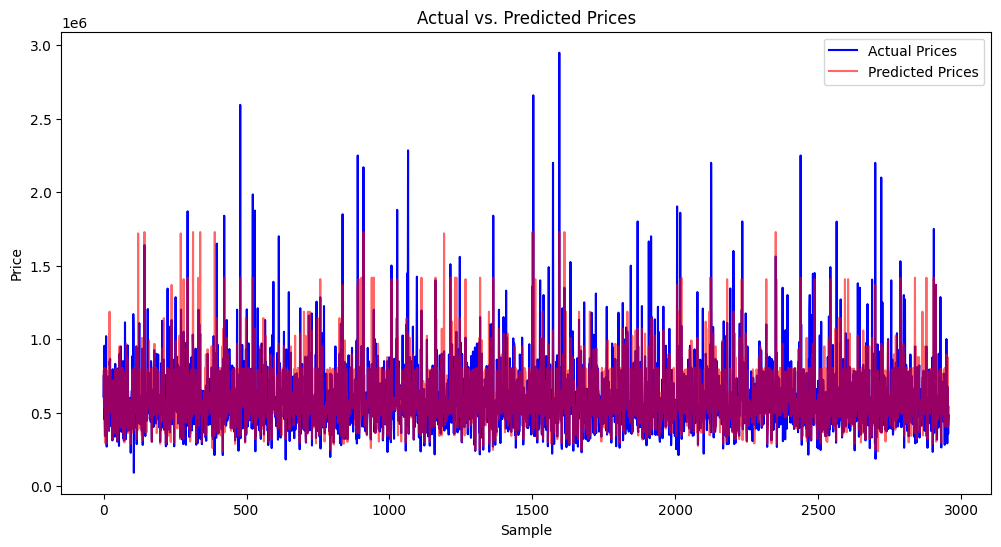

In [1]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor  # Import KNeighborsRegressor
import matplotlib.pyplot as plt

# 1.Data Preparation
url = 'https://raw.github.com/pilfg/MachineLearning/main/properties.csv'
response = requests.get(url)
csv_data = StringIO(response.text)
data = pd.read_csv(csv_data, delimiter=';', encoding='utf-8')

# One-hot encoding for 'propertyType' column
if 'propertyType' in data.columns:
    encoder = OneHotEncoder()
    propertyType_encoded = encoder.fit_transform(data[['propertyType']])
    feature_names = encoder.get_feature_names_out(['propertyType'])
    data = pd.concat([data, pd.DataFrame(propertyType_encoded.toarray(), columns=feature_names)], axis=1)
    data.drop('propertyType', axis=1, inplace=True)

# One-hot encoding for 'postcode' column
if 'postcode' in data.columns:
    encoder = OneHotEncoder()
    postCode_encoded = encoder.fit_transform(data[['postcode']])
    postcode_names = encoder.get_feature_names_out(['postcode'])
    data = pd.concat([data, pd.DataFrame(postCode_encoded.toarray(), columns=postcode_names)], axis=1)
    data.drop('postcode', axis=1, inplace=True)

data = data.drop(data.columns[0], axis=1)
print(data)

# MinMaxScaler for normalization
minmax_scaler = MinMaxScaler()
data_scaled = minmax_scaler.fit_transform(data)

X = data_scaled[:, 1:]
y = data_scaled[:, 0]

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_val = standard_scaler.transform(X_val)
X_test = standard_scaler.transform(X_test)


# 2.K-Nearest Neighbors Regression model

params={'n_neighbors': [7], 
       'weights': ['distance'], 
        'p':[2] 
       }

knn_model = KNeighborsRegressor() 
gs = GridSearchCV(estimator=knn_model, param_grid=params,cv=10, n_jobs=-1)

# 3.Training
gs.fit(X_train, y_train)

# 4.Test
knn_model= gs.best_estimator_
y_test_pred = knn_model.predict(X_test)


predicted_scaled = np.insert(X_test, 0, y_test_pred, axis=1)
predicted_descaled = minmax_scaler.inverse_transform(predicted_scaled)
y_test_pred_descaled = predicted_descaled[:, 0]

y_test_actual_scaled = np.insert(X_test, 0, y_test, axis=1)
y_test_actual_descaled = minmax_scaler.inverse_transform(y_test_actual_scaled)
y_test_descaled = y_test_actual_descaled[:, 0]

mse_descaled = mean_squared_error(y_test_descaled, y_test_pred_descaled)
mae_descaled = mean_absolute_error(y_test_descaled, y_test_pred_descaled)
print(f'Descaled Mean Squared Error on Test Set: {mse_descaled:.4f}')
print(f'Descaled Mean Absolute Error on Test Set: {mae_descaled:.4f}')

# Plots
plt.figure(figsize=(12, 6))
plt.plot(y_test_descaled, label='Actual Prices', color='blue')
plt.plot(y_test_pred_descaled, label='Predicted Prices', color='red', alpha=0.6)
plt.title('Actual vs. Predicted Prices')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()
plt.show()